# Lesion Study Hallway Swapping Analysis 

## Imports

In [51]:
import numpy as np
import polars as pl 
import pandas as pd 
import bambi as bmb
import arviz as az 
import pymc as pm
import platform
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import plotly.express as px 
from IPython.display import display
import ipywidgets
from matching_pennies.io.metrics_store import load_metrics
from matching_pennies.analysis.bambi_plots import plot_trace
from matching_pennies.utils import preprocessing, plotting 

from matching_pennies.utils.search_cols import search_cols

## Load Data

In [52]:
EXPERIMENT = "lesion_study"
PARADIGM = "swapping_hallways" 

system_os = platform.system().lower()

if system_os == "windows":
    hallway_legend_path = "C:/Users/benli/Documents/projects/lesion_study/post_sx_testing/swapping_halls_legend.csv"
    data_path = "C:/Users/benli/Documents/code/matching-pennies/data"
    cores = 4  
    export_path = "C:/Users/benli/Documents/projects/lesion_study/results/paper_analysis/notebook_figures/switching_halls"

elif system_os == "darwin": 
    hallway_legend_path = "/Users/ben/Documents/Data/lesion_study/post_sx_testing/swapping_halls_legend.csv"
    data_path = "/Users/ben/Documents/source/matching-pennies/data"
    cores = 1  # MacOS poops its pants when asked to multithread 

tdf, sdf, manifest = load_metrics(EXPERIMENT, PARADIGM, root=data_path)

In [53]:
# Set category order 
cat = {"treatment": ["sham", "mpfc", "ofc"]}

## Sanity Checks 

In [54]:
preprocessing.summarize_sessions(sdf)

n_animals,min_trials_per_session,min_sessions_per_animal,max_sessions_per_animal
i64,i64,i64,i64
24,156,2,4


## Add Hallway Data to the dataframes 

In [55]:
halls = pl.read_csv(hallway_legend_path)
halls

Animal,Date,Hall
i64,str,str
4669,"""2024-10-06""","""S"""
4666,"""2024-10-06""","""S"""
4667,"""2024-10-06""","""L"""
4668,"""2024-10-06""","""S"""
4663,"""2024-10-06""","""S"""
…,…,…
4650,"""2024-10-20""","""S"""
4645,"""2024-10-20""","""C"""
4653,"""2024-10-20""","""C"""


In [56]:
# Clean up data from csv
halls = halls.with_columns(
    # Convert integer Animal -> string animal_id "P####" 
    pl.format("P{}", pl.col("Animal").cast(pl.Utf8)).cast(pl.Categorical).alias("animal_id"),

    # Convert "Date" string to Date object 
    pl.col("Date").alias("session_date").str.strip_chars('"').str.to_date(format="%Y-%m-%d"),

    # Rename Hall to hall while we're here 
    pl.col("Hall").alias("hall")
).drop(["Animal", "Date", "Hall"])

halls

animal_id,session_date,hall
cat,date,str
"""P4669""",2024-10-06,"""S"""
"""P4666""",2024-10-06,"""S"""
"""P4667""",2024-10-06,"""L"""
"""P4668""",2024-10-06,"""S"""
"""P4663""",2024-10-06,"""S"""
…,…,…
"""P4650""",2024-10-20,"""S"""
"""P4645""",2024-10-20,"""C"""
"""P4653""",2024-10-20,"""C"""


Join the trial and hall dataframes

In [57]:
tdf = tdf.join(halls, on=["animal_id", "session_date"], how="left")

## Cursory look at EFS

Make a truncated dataset for plotting 

In [58]:
tdf_trunc = preprocessing.clip_to_minimum_extent(tdf, "trial_idx")

In [59]:
tdf_bin = preprocessing.bin_data(tdf_trunc, 20)
efs_bin = plotting.bin_and_aggregate_flag(tdf_bin, "EFS_before_flg")
fig = plotting.line_by_treatment_across_bins(
    efs_bin, 
    x="bin", 
    y="EFS_before_flg_fraction",
    category_orders=cat,
    title="EFS over time bins. Bins = 20 trials"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

fig.write_image(export_path + "/efs_bin.svg")

fig.show()

When collapsed across sessions, it looks like OFC lesioned animals had a larger increase in EFS after the hallway swap

Lets take a closer look at each session to see whats going on

### EFS session plots

How many animals are in each session? 

In [60]:
animal_counts = tdf_bin.group_by(["treatment", "session_idx"]).agg(pl.col("animal_id").unique().len()).sort(["treatment", "session_idx"])

In [61]:
efs_bin = plotting.bin_and_aggregate_flag(tdf_bin.filter(pl.col("session_idx") == 1), "EFS_before_flg")
fig = plotting.line_by_treatment_across_bins(
    efs_bin, 
    x="bin", 
    y="EFS_before_flg_fraction",
    category_orders=cat,
    title="Binned EFS: Session 1"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

session = 1
subset = animal_counts.filter(pl.col("session_idx") == session)

fig.add_annotation(
    x=1,
    y = 1,
    xref="paper", yref="paper",
    text="Number of animals in each treatment:",
    showarrow=False,
    font=dict(size=12),
    align="left"
)

# For each treatment, place annotation text
for i, row in enumerate(subset.iter_rows(named=True)):
    fig.add_annotation(
        x=1,                     # x position in axis coordinates
        y=1 - (i + 1)* 0.08,            # vertically offset each treatment
        xref="paper", yref="paper",
        text=f"{row['treatment']}: {row['animal_id']}",
        showarrow=False,
        font=dict(size=12),
        align="left"
    )

fig.show()

In [62]:
session = 2
efs_bin = plotting.bin_and_aggregate_flag(tdf_bin.filter(pl.col("session_idx") == session), "EFS_before_flg")
fig = plotting.line_by_treatment_across_bins(
    efs_bin, 
    x="bin", 
    y="EFS_before_flg_fraction",
    category_orders=cat,
    title=f"Binned EFS: Session {session}"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

subset = animal_counts.filter(pl.col("session_idx") == session)

fig.add_annotation(
    x=1,
    y = 1,
    xref="paper", yref="paper",
    text="Number of animals in each treatment:",
    showarrow=False,
    font=dict(size=12),
    align="left"
)

# For each treatment, place annotation text
for i, row in enumerate(subset.iter_rows(named=True)):
    fig.add_annotation(
        x=1,                     # x position in axis coordinates
        y=1 - (i + 1)* 0.08,            # vertically offset each treatment
        xref="paper", yref="paper",
        text=f"{row['treatment']}: {row['animal_id']}",
        showarrow=False,
        font=dict(size=12),
        align="left"
    )

fig.show()

In [63]:
session = 3
efs_bin = plotting.bin_and_aggregate_flag(tdf_bin.filter(pl.col("session_idx") == session), "EFS_before_flg")
fig = plotting.line_by_treatment_across_bins(
    efs_bin, 
    x="bin", 
    y="EFS_before_flg_fraction",
    category_orders=cat,
    title=f"Binned EFS: Session {session}"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

subset = animal_counts.filter(pl.col("session_idx") == session)

fig.add_annotation(
    x=1,
    y = 1,
    xref="paper", yref="paper",
    text="Number of animals in each treatment:",
    showarrow=False,
    font=dict(size=12),
    align="left"
)

# For each treatment, place annotation text
for i, row in enumerate(subset.iter_rows(named=True)):
    fig.add_annotation(
        x=1,                     # x position in axis coordinates
        y=1 - (i + 1)* 0.08,            # vertically offset each treatment
        xref="paper", yref="paper",
        text=f"{row['treatment']}: {row['animal_id']}",
        showarrow=False,
        font=dict(size=12),
        align="left"
    )

fig.show()

## Hallway EFS GLMM analysis 

The relationship between EFS and lesion group is unclear from the binned plots. Lets fit a GLMM with a `hallway swap` flag (0 < 60 & 1 >= 60) 

Add the flag to the dataframe 

In [64]:
gldf = tdf.clone()

In [65]:
gldf = (
    gldf
    .with_columns(
        pl.when(pl.col("trial_idx") < 60)
        .then(0)
        .otherwise(1)
        .alias("swap_flg") 
    )
)

Scale the number of trials and sessions

In [66]:
gldf = preprocessing.scale_col(gldf, "trial_idx")
gldf = preprocessing.scale_col(gldf, "session_idx") 

df = gldf[["treatment", "animal_id", "session_idx_scaled", "trial_idx_scaled", "EFS_before_flg", "swap_flg"]]
df = df.filter(pl.col("EFS_before_flg").is_not_null())
df = df.to_pandas()
df["treatment"] = pd.Categorical(df["treatment"], categories=["sham", "mpfc", "ofc"], ordered=True)

Define the formula for the model

This model will look at the main effects of: 
- Treatment
- Trial number
- Session number 
- Swap 

and interactions between these and treatment 

In [67]:
hall_efs_formula = "EFS_before_flg ~ treatment * trial_idx_scaled + treatment * session_idx_scaled + treatment * swap_flg + (1 | animal_id)"

In [68]:
model_hall = bmb.Model(
    hall_efs_formula,
    df,
    family="bernoulli"
)

idata_hall = model_hall.fit(idata_kwargs={"log_likelihood": True}, cores=cores, chains=4)

Modeling the probability that EFS_before_flg==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, treatment, trial_idx_scaled, treatment:trial_idx_scaled, session_idx_scaled, treatment:session_idx_scaled, swap_flg, treatment:swap_flg, 1|animal_id_sigma, 1|animal_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [69]:
az.summary(idata_hall)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.600,0.153,-1.889,-1.305,0.004,0.003,1236.0,1652.0,1.01
treatment[mpfc],-0.009,0.201,-0.384,0.378,0.006,0.004,1203.0,1953.0,1.00
treatment[ofc],0.202,0.230,-0.223,0.638,0.006,0.004,1426.0,1685.0,1.00
trial_idx_scaled,-0.440,0.236,-0.885,-0.000,0.006,0.004,1630.0,2374.0,1.01
treatment:trial_idx_scaled[mpfc],0.209,0.334,-0.444,0.798,0.009,0.005,1508.0,2497.0,1.01
treatment:trial_idx_scaled[ofc],0.139,0.349,-0.505,0.792,0.008,0.005,1937.0,2690.0,1.00
session_idx_scaled,-0.559,0.134,-0.806,-0.308,0.003,0.003,1878.0,2268.0,1.00
treatment:session_idx_scaled[mpfc],0.837,0.179,0.503,1.158,0.004,0.003,2011.0,2784.0,1.00
treatment:session_idx_scaled[ofc],0.417,0.206,0.034,0.800,0.004,0.003,2137.0,2673.0,1.00
swap_flg,0.262,0.120,0.045,0.500,0.003,0.002,1634.0,2018.0,1.00


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'treatment'}>,
        <Axes: title={'center': 'treatment'}>],
       [<Axes: title={'center': 'trial_idx_scaled'}>,
        <Axes: title={'center': 'trial_idx_scaled'}>],
       [<Axes: title={'center': 'treatment:trial_idx_scaled'}>,
        <Axes: title={'center': 'treatment:trial_idx_scaled'}>],
       [<Axes: title={'center': 'session_idx_scaled'}>,
        <Axes: title={'center': 'session_idx_scaled'}>],
       [<Axes: title={'center': 'treatment:session_idx_scaled'}>,
        <Axes: title={'center': 'treatment:session_idx_scaled'}>],
       [<Axes: title={'center': 'swap_flg'}>,
        <Axes: title={'center': 'swap_flg'}>],
       [<Axes: title={'center': 'treatment:swap_flg'}>,
        <Axes: title={'center': 'treatment:swap_flg'}>],
       [<Axes: title={'center': '1|animal_id_sigma'}>,
        <Axes: title={'center': '1|animal_id_sigma'}>],
       [<

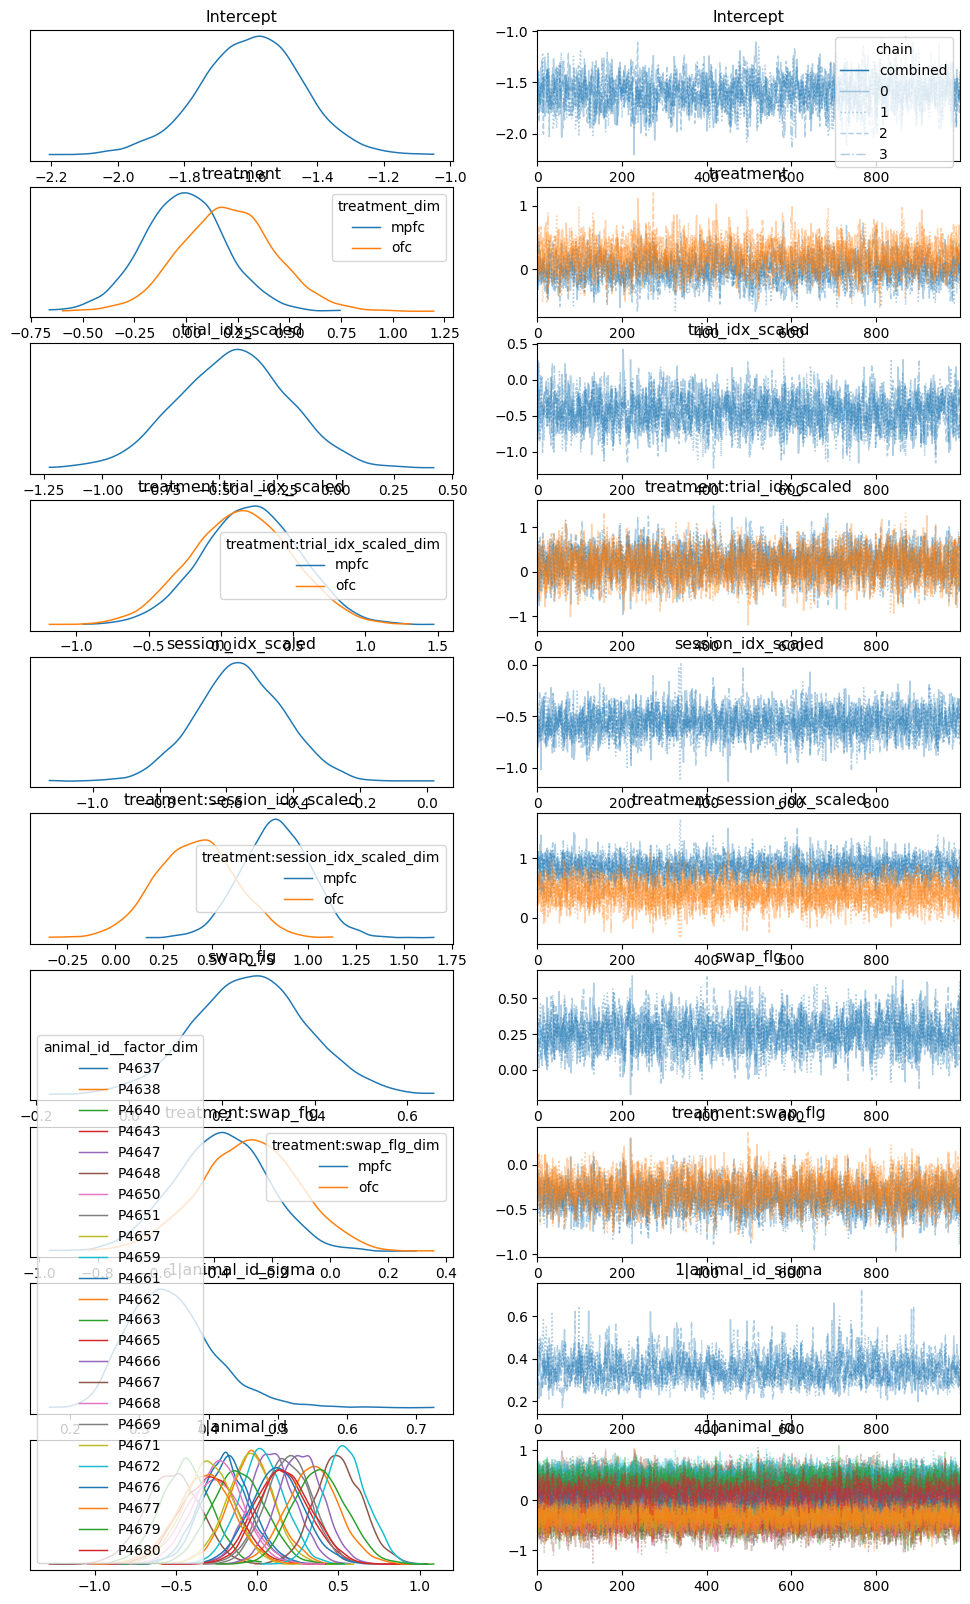

In [70]:
az.plot_trace(idata_hall, legend=True, combined=True)

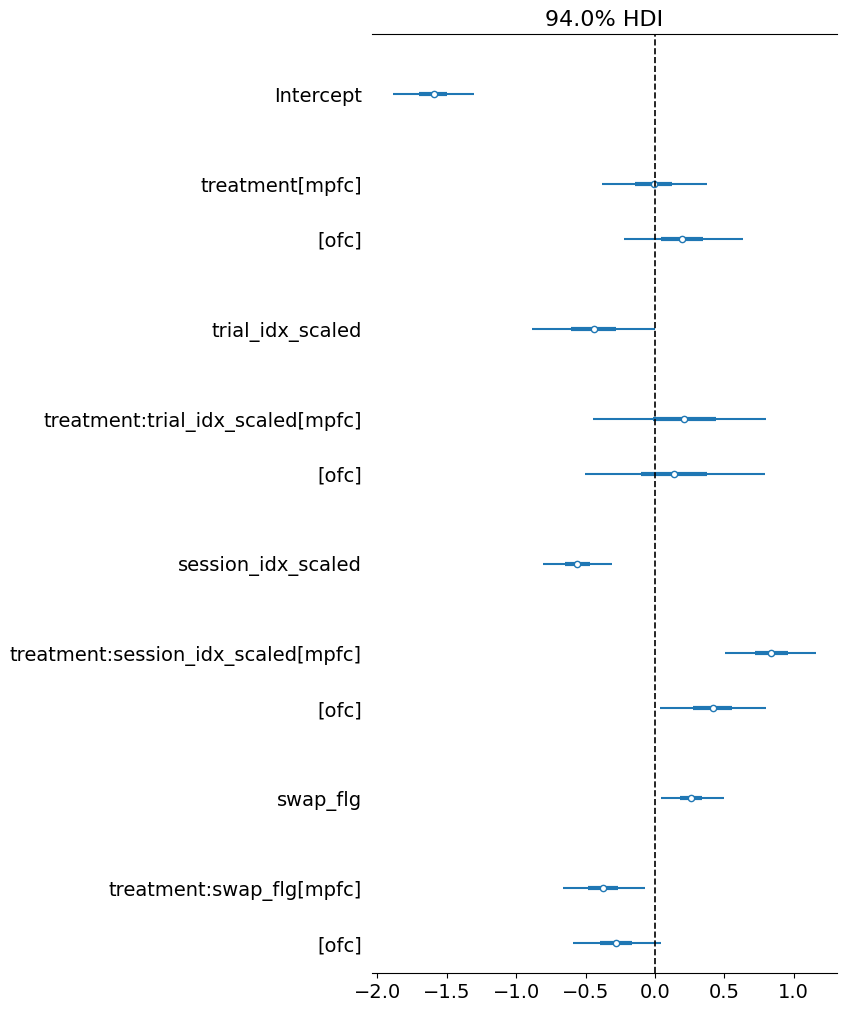

In [71]:
plt_vars = ["Intercept", "treatment", "trial_idx_scaled", "treatment:trial_idx_scaled", "session_idx_scaled", "treatment:session_idx_scaled", "swap_flg", "treatment:swap_flg"]
ax = az.plot_forest(idata_hall, combined=True, var_names=plt_vars, show=False)

ax = ax[0]

# Add a vertical dotted line at x=0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1.2)

plt.savefig(export_path + "/hall_switch_EFS_forest_plot.svg", format="svg")

plt.show()

<Axes: xlabel='EFS_before_flg'>

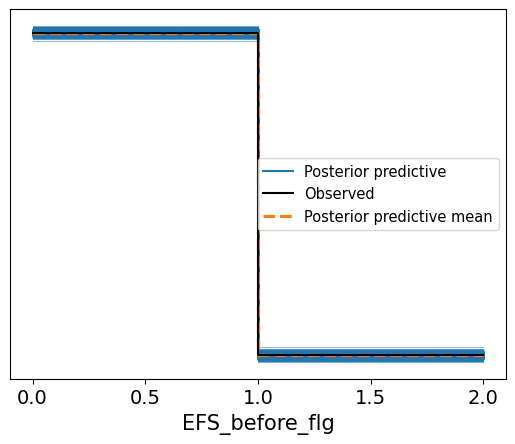

In [72]:
ppc = model_hall.predict(idata_hall, kind="response", inplace=False)
az.plot_ppc(ppc)

Next, lets modify the model to answer th equestion: Do OFC and mPFC rats differ from shams in how their EFS response to the hallway swap evolves over repeated sessions? 

In [73]:
three_way_formula = """ 
EFS_before_flg ~
treatment * session_idx_scaled * swap_flg + 
treatment * trial_idx_scaled + 
(1|animal_id)
"""

In [74]:
model_three_way = bmb.Model(
    three_way_formula, 
    df, 
    family="bernoulli"
)

idata_three_way = model_three_way.fit(idata_kwargs={"log_likelihood": True}, cores=cores, chains=4)
az.summary(idata_three_way)

Modeling the probability that EFS_before_flg==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, treatment, session_idx_scaled, treatment:session_idx_scaled, swap_flg, treatment:swap_flg, session_idx_scaled:swap_flg, treatment:session_idx_scaled:swap_flg, trial_idx_scaled, treatment:trial_idx_scaled, 1|animal_id_sigma, 1|animal_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 108 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.528,0.168,-1.846,-1.222,0.004,0.003,1759.0,2481.0,1.0
treatment[mpfc],0.069,0.216,-0.334,0.463,0.005,0.003,1774.0,2469.0,1.0
treatment[ofc],0.180,0.250,-0.309,0.628,0.006,0.005,1716.0,1600.0,1.0
session_idx_scaled,-0.806,0.294,-1.364,-0.262,0.007,0.005,1617.0,2145.0,1.0
treatment:session_idx_scaled[mpfc],0.611,0.379,-0.099,1.317,0.009,0.006,1623.0,2158.0,1.0
treatment:session_idx_scaled[ofc],0.517,0.423,-0.305,1.263,0.010,0.006,1828.0,2550.0,1.0
swap_flg,0.181,0.146,-0.082,0.457,0.003,0.002,1876.0,2674.0,1.0
treatment:swap_flg[mpfc],-0.509,0.195,-0.865,-0.137,0.004,0.003,2032.0,2730.0,1.0
treatment:swap_flg[ofc],-0.261,0.219,-0.680,0.145,0.005,0.003,1970.0,2807.0,1.0
session_idx_scaled:swap_flg,0.309,0.317,-0.240,0.957,0.008,0.005,1637.0,2308.0,1.0


(<Figure size 1200x2800 with 28 Axes>,
 [<Axes: title={'center': 'Intercept'}>,
  <Axes: title={'center': 'Intercept'}>,
  <Axes: title={'center': 'treatment\nmpfc'}>,
  <Axes: title={'center': 'treatment\nmpfc'}>,
  <Axes: title={'center': 'treatment\nofc'}>,
  <Axes: title={'center': 'treatment\nofc'}>,
  <Axes: title={'center': 'trial_idx_scaled'}>,
  <Axes: title={'center': 'trial_idx_scaled'}>,
  <Axes: title={'center': 'treatment:trial_idx_scaled\nmpfc'}>,
  <Axes: title={'center': 'treatment:trial_idx_scaled\nmpfc'}>,
  <Axes: title={'center': 'treatment:trial_idx_scaled\nofc'}>,
  <Axes: title={'center': 'treatment:trial_idx_scaled\nofc'}>,
  <Axes: title={'center': 'session_idx_scaled'}>,
  <Axes: title={'center': 'session_idx_scaled'}>,
  <Axes: title={'center': 'treatment:session_idx_scaled\nmpfc'}>,
  <Axes: title={'center': 'treatment:session_idx_scaled\nmpfc'}>,
  <Axes: title={'center': 'treatment:session_idx_scaled\nofc'}>,
  <Axes: title={'center': 'treatment:session_i

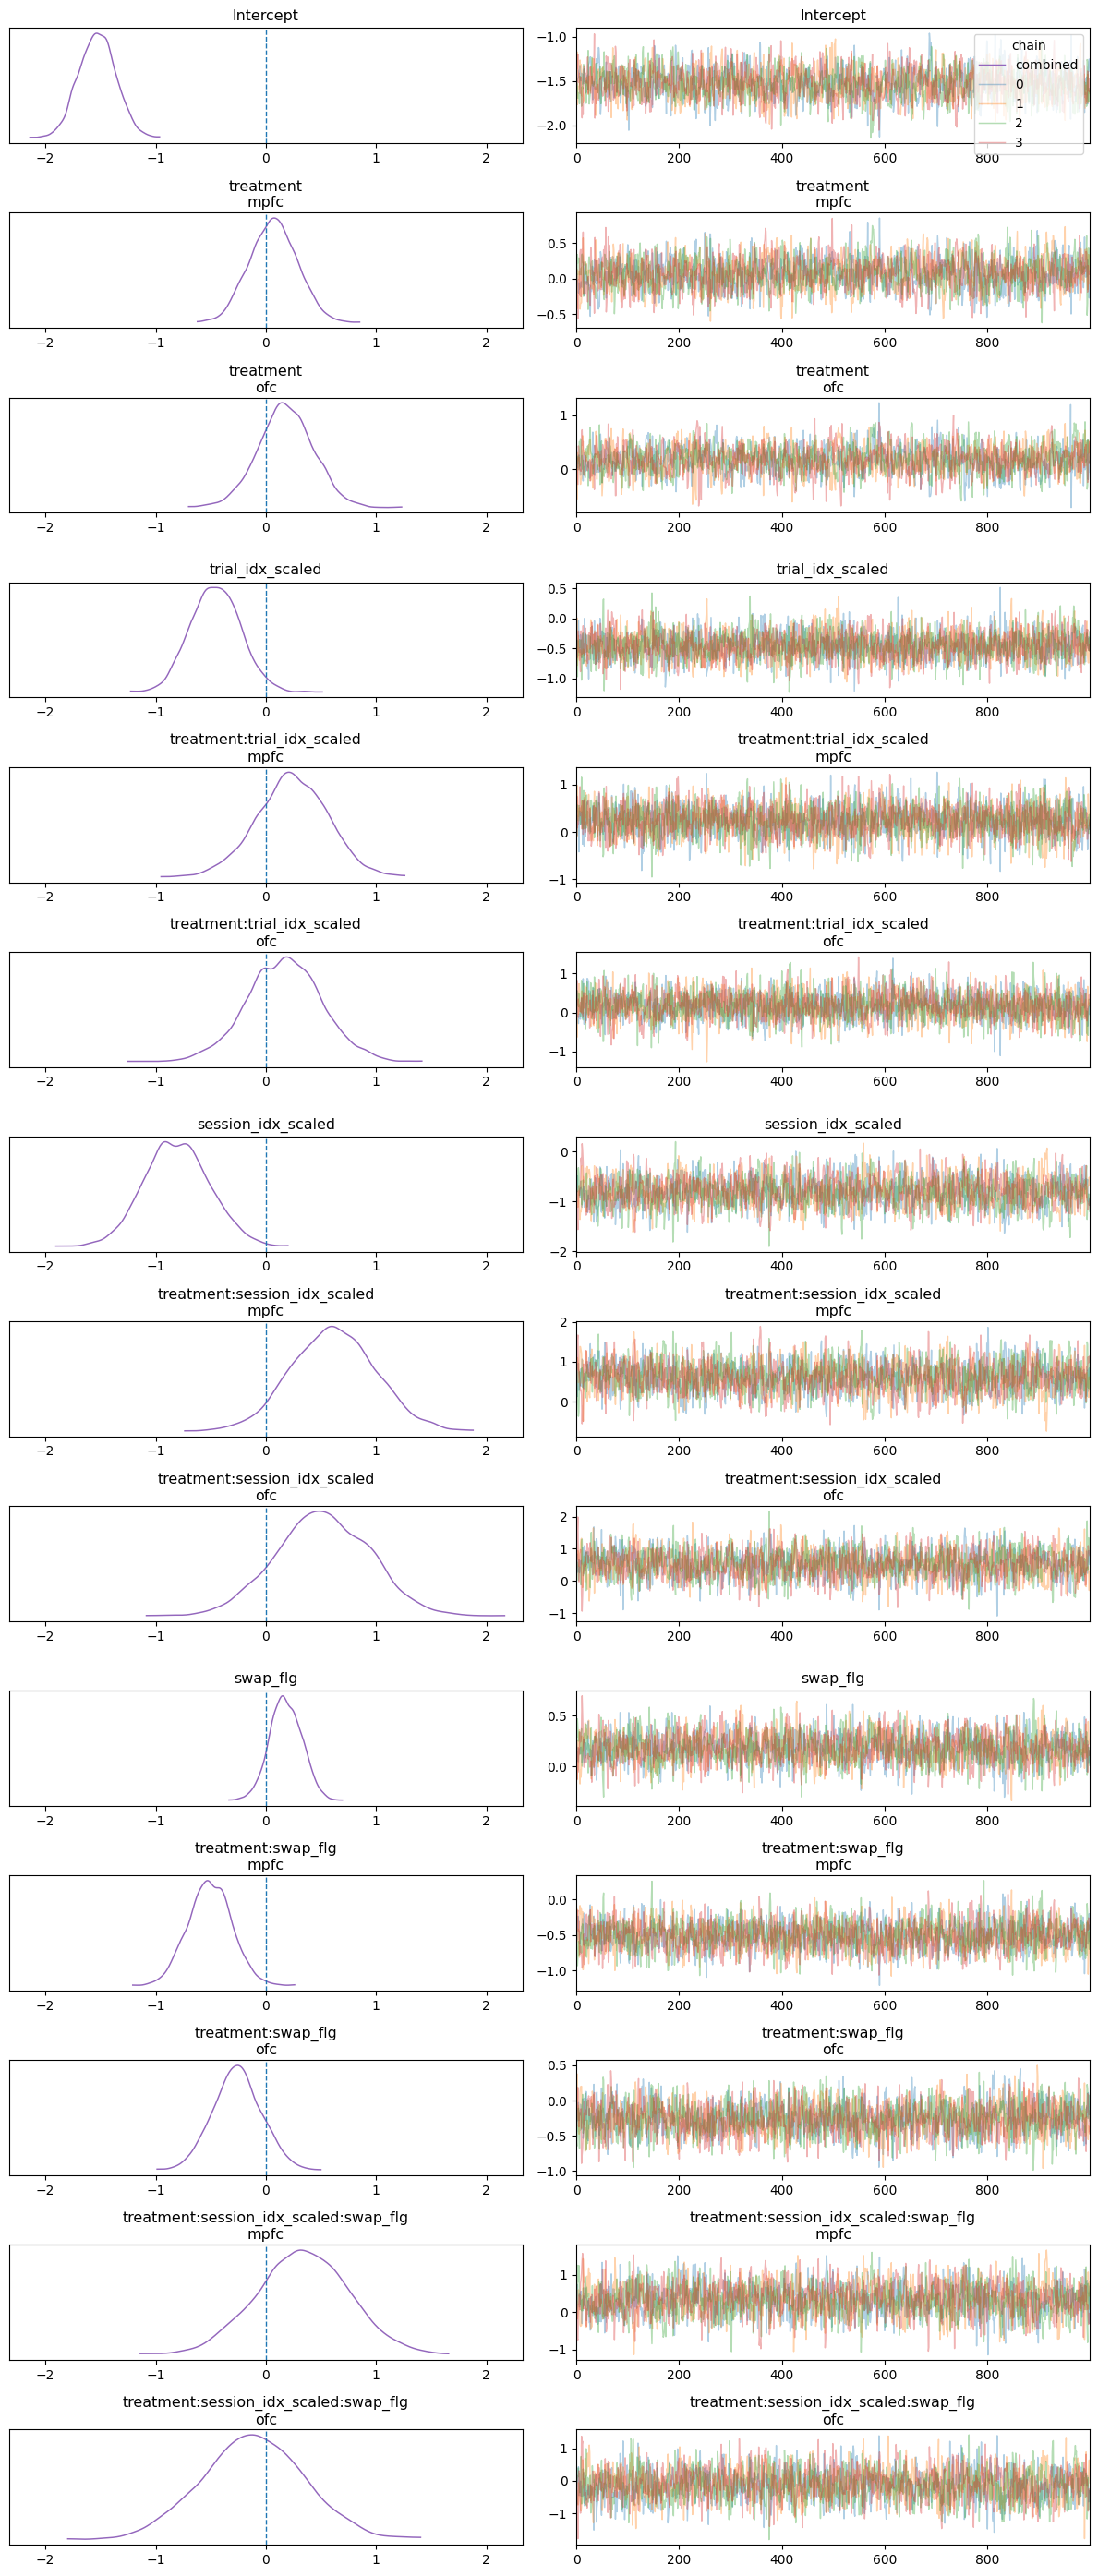

In [75]:
import matching_pennies.analysis.bambi_plots as bp 
three_plot_vars = plt_vars + ["treatment:session_idx_scaled:swap_flg"]
bp.plot_trace(idata_three_way, var_names=three_plot_vars,)

<Axes: xlabel='EFS_before_flg'>

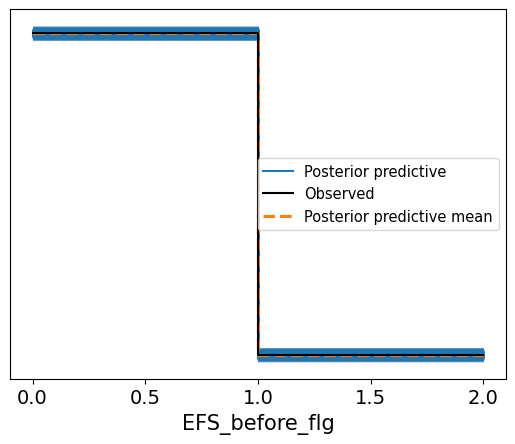

In [76]:
ppc_three = model_three_way.predict(idata_three_way, kind="response", inplace=False) 
az.plot_ppc(ppc_three)

The fits of both models look OK. Lets formally compare them. 

           rank      elpd_loo      p_loo  elpd_diff    weight          se  \
regular       0  15162.505699  31.272444   0.000000  0.546243  156.330965   
three_way     1  15163.142922  34.902357   0.637223  0.453757  156.417204   

                dse  warning     scale  
regular    0.000000    False  deviance  
three_way  5.217221    False  deviance  


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

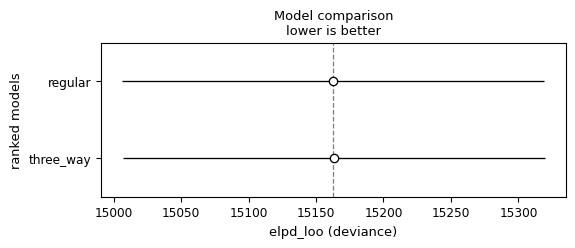

In [77]:
cmp = az.compare(
    {"regular": idata_hall, "three_way": idata_three_way}, 
    ic="loo",
    scale="deviance"
)
print(cmp)
az.plot_compare(cmp)

Conclusion: Models are indistinguishable -> Favour simpler (2-way interaction) model. 

## Other behaviours

### WSLS

Win-Stay

In [78]:
ws_df = plotting.bin_and_aggregate_flag(tdf_bin, "WinStay_NoMultWellResp_flg")
fig = plotting.line_by_treatment_across_bins(
    ws_df, 
    y="WinStay_NoMultWellResp_flg_fraction",
    category_orders=cat,
    title="Win-Stay (without EFS)"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

fig.write_image(export_path + "/win-stay_bins.svg")

fig.show()

In [79]:
ws_df = plotting.bin_and_aggregate_flag(tdf_bin, "WinStay_flg")
fig = plotting.line_by_treatment_across_bins(
    ws_df, 
    y="WinStay_flg_fraction",
    category_orders=cat,
    title="Win-Stay (with EFS)"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

fig.show()

Fit quick GLMM for win-stay

In [80]:
df = gldf[["treatment", "animal_id", "session_idx_scaled", "trial_idx_scaled", "WinStay_NoMultWellResp_flg", "swap_flg"]]
df = df.filter(pl.col("WinStay_NoMultWellResp_flg").is_not_null())
df = df.to_pandas()
df["treatment"] = pd.Categorical(df["treatment"], categories=["sham", "mpfc", "ofc"], ordered=True)

In [81]:
ws_form = "WinStay_NoMultWellResp_flg ~ treatment * trial_idx_scaled + treatment * session_idx_scaled + treatment * swap_flg + (1|animal_id)"
ws_model = bmb.Model(
    ws_form, 
    df, 
    family="bernoulli"
)
ws_idata = ws_model.fit(cores=cores, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(ws_idata)

Modeling the probability that WinStay_NoMultWellResp_flg==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, treatment, trial_idx_scaled, treatment:trial_idx_scaled, session_idx_scaled, treatment:session_idx_scaled, swap_flg, treatment:swap_flg, 1|animal_id_sigma, 1|animal_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.290,0.148,-0.577,-0.021,0.004,0.003,1318.0,1872.0,1.0
treatment[mpfc],0.362,0.197,-0.017,0.724,0.005,0.004,1439.0,2103.0,1.0
treatment[ofc],0.209,0.224,-0.207,0.632,0.006,0.004,1280.0,2045.0,1.0
trial_idx_scaled,0.755,0.274,0.246,1.270,0.007,0.004,1746.0,2490.0,1.0
treatment:trial_idx_scaled[mpfc],0.032,0.398,-0.722,0.753,0.009,0.006,2030.0,2425.0,1.0
treatment:trial_idx_scaled[ofc],-0.194,0.419,-0.963,0.591,0.010,0.006,1872.0,2468.0,1.0
session_idx_scaled,1.092,0.158,0.803,1.395,0.003,0.002,2097.0,2402.0,1.0
treatment:session_idx_scaled[mpfc],-0.860,0.217,-1.276,-0.463,0.005,0.003,2259.0,2581.0,1.0
treatment:session_idx_scaled[ofc],-0.556,0.252,-1.028,-0.102,0.005,0.003,2412.0,2855.0,1.0
swap_flg,-0.006,0.140,-0.273,0.253,0.004,0.002,1454.0,2717.0,1.0


<Axes: xlabel='WinStay_NoMultWellResp_flg'>

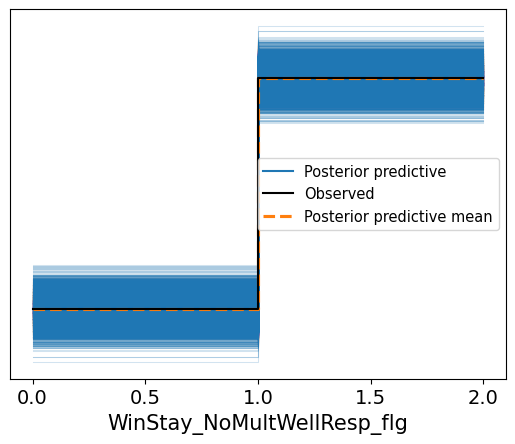

In [82]:
ppc = ws_model.predict(ws_idata, kind="response", inplace=False) 
az.plot_ppc(ppc)

Look at how win-stay changes over sessions: 

In [83]:
session = 1
ws_df = plotting.bin_and_aggregate_flag(tdf_bin.filter(pl.col("session_idx") == session), "WinStay_NoMultWellResp_flg")
fig = plotting.line_by_treatment_across_bins(
    ws_df, 
    y="WinStay_NoMultWellResp_flg_fraction",
    category_orders=cat,
    title=f"Win-Stay (without EFS) in session {session}"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

fig.show()

In [84]:
session = 2
ws_df = plotting.bin_and_aggregate_flag(tdf_bin.filter(pl.col("session_idx") == session), "WinStay_NoMultWellResp_flg")
fig = plotting.line_by_treatment_across_bins(
    ws_df, 
    y="WinStay_NoMultWellResp_flg_fraction",
    category_orders=cat,
    title=f"Win-Stay (without EFS) in session {session}"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

fig.show()

In [85]:
session = 3
ws_df = plotting.bin_and_aggregate_flag(tdf_bin.filter(pl.col("session_idx") == session), "WinStay_NoMultWellResp_flg")
fig = plotting.line_by_treatment_across_bins(
    ws_df, 
    y="WinStay_NoMultWellResp_flg_fraction",
    category_orders=cat,
    title=f"Win-Stay (without EFS) in session {session}"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

fig.show()

Lose-Switch 

In [86]:
ls_df = plotting.bin_and_aggregate_flag(tdf_bin, "LoseSwitch_NoMultWellResp_flg")
fig = plotting.line_by_treatment_across_bins(
    ls_df, 
    y="LoseSwitch_NoMultWellResp_flg_fraction",
    category_orders=cat,
    title="Lose-Switch (without EFS)"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

fig.write_image(export_path + "/lose-switch_bins.svg")

fig.show()

### Error probability

It looks like win-stay decreases dramatically after the hallway swap. Is this just due to an increase in losses? 

In [87]:
err_df = plotting.bin_and_aggregate_flag(tdf_bin, "error_flg")
fig = plotting.line_by_treatment_across_bins(
    err_df, 
    y="error_flg_fraction", 
    category_orders=cat, 
    title="Error Probability"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

fig.write_image(export_path + "/error_probability.svg")

fig.show()

### Licks

Licks Before Reward

In [88]:
lbr_df = plotting.bin_and_aggregate_flag(tdf_bin, "LicksBeforeRew")
fig = plotting.line_by_treatment_across_bins(
    lbr_df, 
    y="LicksBeforeRew_fraction",
    category_orders=cat
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

fig.show()

Total Licks 

In [89]:
tl_df = plotting.bin_and_aggregate_flag(tdf_bin, "LicksTotal")
fig = plotting.line_by_treatment_across_bins(
    tl_df, 
    y="LicksTotal_fraction", 
    category_orders=cat,
    title="Total Licks" 
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

fig.write_image(export_path + "/total_licks_bins.svg")

fig.show()

### Inter-Trial Interval 

In [90]:
iti_df = plotting.bin_and_aggregate_flag(tdf_bin, "InterTrialInterval")
fig = plotting.line_by_treatment_across_bins(
    iti_df, 
    y="InterTrialInterval_fraction", 
    category_orders=cat, 
    title="Inter-Trial Interval (ms)"
)

fig.add_vline(
    x=3,
    line_dash="dot",
    line_color="black",
    annotation_text="Hall swap",
    annotation_position="bottom right"
)

fig.write_image(export_path + "/ITI_bins.svg")

fig.show()

In [91]:
tdf_bin["InterTrialInterval"]

InterTrialInterval
f64
null
null
2586.0
22382.0
26009.0
…
1671.0
956.0
1403.0


## ANOVAs 

We want to perform ANOVAs in the time bin before and after the hallway swap 

Here we will split the dataset into two bins. The first is trials 40-59, the next is trials 60-79. The hallway swap happens at trial 60

In [92]:
filt_df = (
    tdf
    .filter(
        (pl.col("trial_idx") >= 40) & (pl.col("trial_idx") <= 79)
    )
    .with_columns(
        swap = pl.when(pl.col("trial_idx") < 60)
            .then(0)
            .otherwise(1)
    )
)
filt_df

trial_idx,max_trials,mode,repeat_wrong,win_delays,lose_delays,L_win_L_delay,L_lose_L_delay,R_win_L_delay,R_lose_L_delay,R_win_R_delay,R_lose_R_delay,L_win_R_delay,L_lose_R_delay,odor1_id,odor1_delay,odor1_duration,odor2_id,odor2_delay,odor2_duration,tone_delay,tone_duration,tone_period,L_reward_id,L_reward_delay,L_reward_duration,L_reward_num,L_bolus_delay,R_reward_id,R_reward_delay,R_reward_duration,R_reward_num,R_bolus_delay,trial_delay,error_duration,odor_port_error,well_error,…,source_file,139126%P,402371xf,experiment,treatment,paradigm,session_idx,n_L_licks,n_R_licks,LicksTotal,LicksBeforeRew,InterTrialInterval,LastTrialRewarded_flg,ChoiceSwitchFromLastTrial,ProbRepeat,WinStay_flg,WinSwitch_flg,LoseSwitch_flg,LoseStay_flg,WSLS_flg,EFS_before_flg,EFS_after_flg,WinStay_NoMultWellResp_flg,LoseSwitch_NoMultWellResp_flg,DidNP_flg,DidNPandWellResp_flg,NumRewards,DidNPandWellResp_cumsum,IFA_cumsum,NumRewBoli_cumsum,NumRewTrials_cumsum,InitTime,ReactTime,ResponseTime,TimeInWell,hall,swap
u32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,cat,cat,cat,i32,u32,u32,u32,u32,f64,f64,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i64,i64,i64,i64,f64,f64,f64,f64,str,i32
40,"""Inf""","""Mode 2""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""150""","""160""","""1""","""0""","""250""","""1""","""0""","""1""","""0""","""200""","""1""","""0""","""1""","""1""","""0""","""0""",…,"""C:\Users\benli\Documents\proje…",null,null,"""lesion_mpfc_ofc_ben""","""sham""","""swap""",1,0,0,null,null,1876.0,0.0,1,0,null,null,1,0,1,0,0,null,1,1,1,0,40,5,18,18,1348.0,301.0,864.0,-2431.0,"""S""",0
41,"""Inf""","""Mode 2""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""150""","""160""","""1""","""0""","""250""","""1""","""0""","""1""","""0""","""200""","""1""","""0""","""1""","""1""","""0""","""0""",…,"""C:\Users\benli\Documents\proje…",null,null,"""lesion_mpfc_ofc_ben""","""sham""","""swap""",1,12,0,12,0,4350.0,0.0,1,0,null,null,1,0,1,0,0,null,1,1,1,0,41,5,18,18,1969.0,302.0,979.0,56.0,"""S""",0
42,"""Inf""","""Mode 2""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""150""","""160""","""1""","""0""","""250""","""1""","""0""","""1""","""0""","""200""","""1""","""0""","""1""","""1""","""0""","""0""",…,"""C:\Users\benli\Documents\proje…",null,null,"""lesion_mpfc_ofc_ben""","""sham""","""swap""",1,0,0,null,null,28305.0,0.0,0,1,null,null,0,1,0,0,0,null,0,1,1,1,42,5,19,19,26585.0,259.0,1028.0,213.0,"""S""",0
43,"""Inf""","""Mode 2""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""150""","""160""","""1""","""0""","""250""","""1""","""0""","""1""","""0""","""200""","""1""","""0""","""1""","""1""","""0""","""0""",…,"""C:\Users\benli\Documents\proje…",null,null,"""lesion_mpfc_ofc_ben""","""sham""","""swap""",1,0,11,11,0,6977.0,1.0,1,0,0,1,null,null,0,0,0,0,null,1,1,0,43,5,19,19,1155.0,637.0,1038.0,-2835.0,"""S""",0
44,"""Inf""","""Mode 2""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""150""","""160""","""1""","""0""","""250""","""1""","""0""","""1""","""0""","""200""","""1""","""0""","""1""","""1""","""0""","""0""",…,"""C:\Users\benli\Documents\proje…",null,null,"""lesion_mpfc_ofc_ben""","""sham""","""swap""",1,5,0,5,0,1856.0,0.0,1,0,null,null,1,0,1,0,0,null,1,1,1,0,44,5,19,19,1031.0,189.0,1549.0,-2773.0,"""S""",0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
75,"""Inf

In [93]:
efs_delta = (
    filt_df
    .group_by(["treatment", "animal_id", "session_idx", "swap"])
    .agg(efs_sum = pl.sum("EFS_before_flg"))
).sort(["treatment", "animal_id", "session_idx"])

efs_pivot = (
    efs_delta
    .group_by(["treatment", "animal_id", "swap"])
    .agg(pl.mean("efs_sum"))
    .pivot(
        values="efs_sum",
        index=["treatment", "animal_id"],
        on="swap"
    )
    .rename({"0": "efs_sum_pre", "1": "efs_sum_post"})
    .with_columns(
        efs_delta = (pl.col("efs_sum_post") - pl.col("efs_sum_pre"))
    )
).sort(["treatment", "animal_id"])

efs_delta, efs_pivot

(shape: (136, 5)
 ┌───────────┬───────────┬─────────────┬──────┬─────────┐
 │ treatment ┆ animal_id ┆ session_idx ┆ swap ┆ efs_sum │
 │ ---       ┆ ---       ┆ ---         ┆ ---  ┆ ---     │
 │ cat       ┆ cat       ┆ i32         ┆ i32  ┆ i64     │
 ╞═══════════╪═══════════╪═════════════╪══════╪═════════╡
 │ mpfc      ┆ P4640     ┆ 1           ┆ 1    ┆ 4       │
 │ mpfc      ┆ P4640     ┆ 1           ┆ 0    ┆ 2       │
 │ mpfc      ┆ P4640     ┆ 2           ┆ 0    ┆ 3       │
 │ mpfc      ┆ P4640     ┆ 2           ┆ 1    ┆ 5       │
 │ mpfc      ┆ P4640     ┆ 3           ┆ 0    ┆ 0       │
 │ …         ┆ …         ┆ …           ┆ …    ┆ …       │
 │ sham      ┆ P4676     ┆ 2           ┆ 1    ┆ 2       │
 │ sham      ┆ P4677     ┆ 1           ┆ 0    ┆ 3       │
 │ sham      ┆ P4677     ┆ 1           ┆ 1    ┆ 4       │
 │ sham      ┆ P4677     ┆ 2           ┆ 0    ┆ 1       │
 │ sham      ┆ P4677     ┆ 2           ┆ 1    ┆ 1       │
 └───────────┴───────────┴─────────────┴──────┴────────

C:\Users\benli\AppData\Local\Temp\ipykernel_22448\801905934.py:50: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



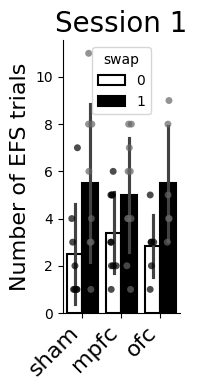

In [94]:
df = efs_delta.filter(pl.col("session_idx") == 1).to_pandas()
df["treatment"] = df["treatment"].astype(str)

fig, ax = plt.subplots(figsize=(2, 4))

palette = ["#FFFFFF", "#000000"]
gray = ["#000000", "#656565"]

# Barplot 
sns.barplot(
    data=df,
    x="treatment", 
    y="efs_sum", 
    hue="swap", 
    order=["sham", "mpfc", "ofc"],
    ax=ax,
    # color="white",
    palette=sns.color_palette(palette),
    errorbar="sd"
)

# Add black borders to bars 
for patch in ax.patches:
    patch.set_edgecolor("black")
    patch.set_linewidth(1.5)

# Stripplot overlay 
sns.stripplot(
    data=df,
    x="treatment", 
    y="efs_sum",
    hue="swap", 
    order=["sham", "mpfc", "ofc"],
    ax=ax,
    palette=sns.color_palette(gray),
    jitter=0.15,
    alpha=0.7,
    dodge=True
)

# Labels and formatting 

handles, labels = ax.get_legend_handles_labels()
# keep only first two (swap 0/1)
ax.legend(handles[:2], labels[:2], title="swap")

ax.set_title("Session 1", fontsize=20)
ax.set_ylabel("Number of EFS trials", fontsize=16)
ax.set_xlabel(""), 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=16)

sns.despine()
plt.tight_layout()

C:\Users\benli\AppData\Local\Temp\ipykernel_22448\2729784518.py:55: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\benli\AppData\Local\Temp\ipykernel_22448\2729784518.py:55: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\benli\AppData\Local\Temp\ipykernel_22448\2729784518.py:55: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



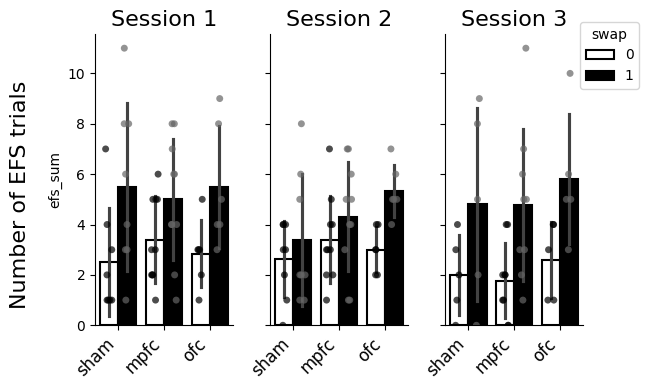

In [95]:
sessions = [1, 2, 3]

fig, axes = plt.subplots(
    nrows=1, ncols=3,
    figsize=(6, 4),
    sharey=True
)

palette = ["#FFFFFF", "#000000"]
gray = ["#000000", "#656565"]

for ax, sess in zip(axes, sessions):

    df = efs_delta.filter(pl.col("session_idx") == sess).to_pandas()
    df["treatment"] = df["treatment"].astype(str)

    # Barplot
    sns.barplot(
        data=df,
        x="treatment",
        y="efs_sum",
        hue="swap",
        order=["sham", "mpfc", "ofc"],
        ax=ax,
        palette=sns.color_palette(palette),
        errorbar="sd"
    )

    # Add bar borders
    for patch in ax.patches:
        patch.set_edgecolor("black")
        patch.set_linewidth(1.5)

    # Stripplot
    sns.stripplot(
        data=df,
        x="treatment",
        y="efs_sum",
        hue="swap",
        order=["sham", "mpfc", "ofc"],
        ax=ax,
        palette=sns.color_palette(gray),
        jitter=0.15,
        alpha=0.7,
        dodge=True
    )

    # Remove duplicate legends in each subplot
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([], [], frameon=False)

    # Title + formatting
    ax.set_title(f"Session {sess}", fontsize=16)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)

# Add ONE shared legend for the figure
fig.legend(
    handles[:2],   # swap 0 & 1
    labels[:2],
    title="swap",
    loc="upper right",
    bbox_to_anchor=(1.08, 0.95)
)

fig.supylabel("Number of EFS trials", fontsize=16)

sns.despine()
plt.tight_layout()
plt.show()

fig.savefig(
    fname="C:/Users/benli/Documents/projects/lesion_study/results/paper_analysis/notebook_figures/switching_halls/session_measures/efs_pre_post_swap.svg",
    format="svg"
)

C:\Users\benli\Documents\code\matching-pennies\matching_pennies\utils\plotting.py:221: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



(<Figure size 200x400 with 1 Axes>,
 <Axes: ylabel='Change in EFS (post - pre)'>)

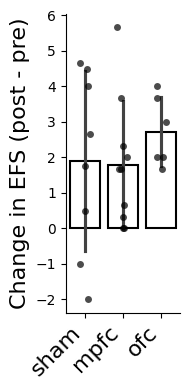

In [96]:
plotting.plot_whitebar_strip(efs_pivot, y_col="efs_delta", ylabel="Change in EFS (post - pre)")

Run a Kruskal-Walis test on the delta EFS (not normally distributed) 

In [97]:
pooled = efs_pivot.to_pandas()
pooled["treatment"] = pooled["treatment"].astype(str) 

groups = [
    pooled.loc[pooled["treatment"] == g, "efs_delta"]
    for g in ["sham", "mpfc", "ofc"]
]

stats.kruskal(*groups)

KruskalResult(statistic=np.float64(1.5638447299651608), pvalue=np.float64(0.45752563411554514))